# Model evaluation code
This code imports and checks the trained agent, and creates an assortment of plots

In [2]:
import pandas as pd

#import gym
import numpy as np
from stable_baselines3 import A2C, DDPG, SAC, PPO
from matplotlib import axis
#import numpy as np
from floris.tools import FlorisInterface
from floris.tools.visualization import visualize_cut_plane
import matplotlib.pyplot as plt
#import matplotlib.pyplot as plt
#from floris.tools.optimization.yaw_optimization.yaw_optimizer_sr import YawOptimizationSR

#Importing custom environment.
from Custom_functions import CustomEnv, CustomEnv2
import copy

Choose the name of the model you want to test:

In [3]:
model_compare = "PPO4"

df = pd.read_excel (r'Results\Overview.xlsx')

index = df[df["Model name"]==model_compare].index.values[0]
print(index)

6


This then sets up the environment, according to the test document 

In [4]:
Model_name = df["Model name"][index]
t_steps = df["t_steps"][index]
dist = df["dist"][index]
nx = df["nx"][index]
ny = df["ny"][index]
turb_type = df["turb_type"][index]
combination = df["combination"][index]
deflection = df["deflection"][index]
turbulence = df["turbulence"][index]
velocity = df["velocity"][index]
WS_min = df["WS_min"][index]
WS_max = df["WS_max"][index]
TI_min = df["TI_min"][index]
TI_max = df["TI_max"][index]
wd_min = df["wd_min"][index]
wd_max = df["wd_max"][index]
yaw_max = df["yaw_max"][index]
rho = df["rho"][index]

env = CustomEnv2(t_steps, dist, nx, ny, turb_type, combination, deflection,
               turbulence, velocity, WS_min, WS_max, TI_min, TI_max, wd_min, wd_max, 
               yaw_max, rho)



Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Then we load either PPO or A2C model:

In [135]:
model_path = "models/"+model_compare+"/475000"

if Model_name[0:3] == "PPO":
    model = PPO.load(model_path, env=env)
    print("PPO model loaded")
if Model_name[0:3] == "A2C":
    model = A2C.load(model_path, env=env)
    print("A2C model loaded")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PPO model loaded


Creates Floris class

In [5]:
#Creates the base for the farm
fi = FlorisInterface("gch.yaml")   

#Turns it into a dictionary and then does the changes to the model
fi_dict = fi.floris.as_dict()

fi_dict["farm"]["turbine_type"] = [turb_type]
fi_dict["wake"]["model_strings"]["combination_model"] = combination
fi_dict["wake"]["model_strings"]["deflection_model"]  = deflection
fi_dict["wake"]["model_strings"]["turbulence_model"]  = turbulence
fi_dict["wake"]["model_strings"]["velocity_model"]    = velocity
fi_dict["flow_field"]["air_density"]                  = rho

# Turns it back into a floris object:
fi = FlorisInterface(fi_dict)

D = fi.floris.farm.rotor_diameters[0]

x = np.linspace(0, D*dist*nx, nx)
y = np.linspace(0, D*dist*ny, ny)

xv, yv = np.meshgrid(x, y, indexing='xy')

layout_x =  xv.flatten()
layout_y = yv.flatten()

fi.reinitialize(
            layout=(layout_x, layout_y),
            )


Does the simulations for the wind directions 

In [6]:
TI = TI_min

actions = []
agent_power = []
baseline_power = []
wind_dirs = []
yaw_angles = np.zeros((1, 1, nx*ny)) 
yaw_zero = np.zeros((1, 1, nx*ny)) 

wind_speed = 7



ws_norm = (wind_speed - env.ws_range_min)/(env.ws_range_max - env.ws_range_min)
TI_norm = (TI - env.ti_range_min)/(env.ti_range_max - env.ti_range_min)  


for wind_dir in range(wd_min, wd_max+1):
    wind_dirs.append(wind_dir)
    wd_norm = (wind_dir - env.wd_range_min)/(env.wd_range_max - env.wd_range_min)
    #observation = np.array([self.wd_norm, self.ws_norm, self.TI_norm], dtype = np.float32)
    observation = np.array([wd_norm, ws_norm, TI_norm], dtype = np.float32)

    action, _states = model.predict(observation, deterministic=True)
    
    action = action*env.yaw_max   #scales the action to the 
    actions.append(action)
    
    fi.reinitialize(
        wind_directions=[wind_dir],
        turbulence_intensity= TI,
        wind_speeds=[wind_speed]
        )
    
    yaw_angles[0,0,:] = action
    fi.calculate_wake(yaw_angles = yaw_zero)
    
    baseline_power.append(fi.get_farm_power()[0][0])
    
    fi.calculate_wake(yaw_angles = yaw_angles)
    agent_power.append(fi.get_farm_power()[0][0])
        
        

actions = np.array(actions)
np.unique(actions,axis = 0)

baseline_power = np.array(baseline_power)
agent_power = np.array(agent_power)
wind_dirs = np.array(wind_dirs)

print("done")

done


In [42]:
print("The wind direction and the yaw angles are:")
for i in range(len(actions)):
    
    print(f"Wind dir: {wind_dirs[i]}|T 1:{actions[i,0]}|T 2:{actions[i,1]}|T 3:{actions[i,2]:.2f}|T 4:{actions[i,3]:.2f}|T 5:{actions[i,4]:.2f}|T 6:{actions[i,5]:.2f}|T 7:{actions[i,6]:.2f}|T 8:{actions[i,7]:.2f}|T 9:{actions[i,8]:.2f}")

    

Wind dir: 270|T 1:30.0|T 2:30.0|T 3:1.00|T 4:30.00|T 5:30.00|T 6:-4.03|T 7:30.00|T 8:30.00|T 9:-6.58
Wind dir: 271|T 1:30.0|T 2:30.0|T 3:1.07|T 4:30.00|T 5:30.00|T 6:-3.93|T 7:30.00|T 8:30.00|T 9:-6.34
Wind dir: 272|T 1:30.0|T 2:30.0|T 3:1.14|T 4:30.00|T 5:30.00|T 6:-3.83|T 7:30.00|T 8:30.00|T 9:-6.10
Wind dir: 273|T 1:30.0|T 2:30.0|T 3:1.22|T 4:30.00|T 5:30.00|T 6:-3.74|T 7:30.00|T 8:30.00|T 9:-5.85
Wind dir: 274|T 1:30.0|T 2:30.0|T 3:1.29|T 4:30.00|T 5:30.00|T 6:-3.64|T 7:30.00|T 8:30.00|T 9:-5.60
Wind dir: 275|T 1:30.0|T 2:30.0|T 3:1.36|T 4:30.00|T 5:30.00|T 6:-3.54|T 7:30.00|T 8:30.00|T 9:-5.36
Wind dir: 276|T 1:30.0|T 2:30.0|T 3:1.44|T 4:30.00|T 5:30.00|T 6:-3.44|T 7:30.00|T 8:30.00|T 9:-5.11
Wind dir: 277|T 1:30.0|T 2:30.0|T 3:1.51|T 4:30.00|T 5:30.00|T 6:-3.35|T 7:30.00|T 8:30.00|T 9:-4.86
Wind dir: 278|T 1:30.0|T 2:30.0|T 3:1.58|T 4:30.00|T 5:30.00|T 6:-3.25|T 7:30.00|T 8:30.00|T 9:-4.62
Wind dir: 279|T 1:30.0|T 2:30.0|T 3:1.66|T 4:30.00|T 5:30.00|T 6:-3.15|T 7:30.00|T 8:30.00|

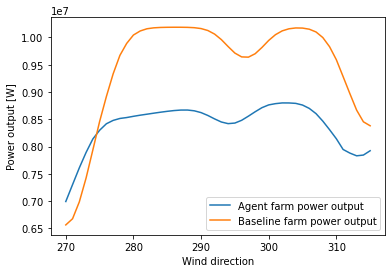

In [136]:
#Plots the power outputs

plt.plot(wind_dirs, agent_power, label = "Agent farm power output")
plt.plot(wind_dirs, baseline_power, label = "Baseline farm power output")
plt.ylabel('Power output [W]')
plt.xlabel('Wind direction')
plt.legend()
plt.show()

In [79]:
obs_wd = []
obs_ws = []
obs_ti = []
rew = []
reward = 0
obs = env.reset()
i = 0
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)
    reward = reward + rewards
    obs_wd.append(obs[0])
    obs_ws.append(obs[1])
    obs_ti.append(obs[2])
    rew.append(rewards)
    print(done, i, rewards)
    i += 1
print("total reward:", reward)

False 0 -0.02531997672624814
False 1 -0.3388237835616716
False 2 -0.03428218295512694
False 3 -0.30530989712114237
False 4 0.443004803241524
False 5 -0.27770011641406733
False 6 -0.05262656045047616
False 7 0.10685931524222805
False 8 -0.12689739060768723
False 9 -0.026432891956613372
False 10 0.46907697408209853
False 11 0.06475126994492339
False 12 -0.01537606644689924
False 13 0.9309045217277387
False 14 0.1664923177780572
False 15 -0.018257092134550432
False 16 -0.06511086539772762
False 17 0.4398814724805647
False 18 -0.06295857483792223
False 19 0.78769941126088
False 20 0.24127356737244582
False 21 0.9398439884429517
False 22 -0.17813780201889248
False 23 0.03849099153217303
False 24 0.0002701526741888096
False 25 0.7446732429643736
False 26 0.9540403354099206
False 27 0.015220535146809273
False 28 -0.04492440294961623
False 29 0.09054495518078336
False 30 -0.0033872462293307337
False 31 0.5411532128639086
False 32 0.07324252453710048
False 33 -0.25156315828487835
False 34 0.005

In [83]:
obs_wd = np.array(obs_wd)
obs_ws = np.array(obs_ws)
obs_ti = np.array(obs_ti)
rew    = np.array(rew)

In [85]:
wd_scaled = obs_wd*(env.wd_range_max - env.wd_range_min) + env.wd_range_min
ws_scaled = obs_ws*(env.ws_range_max - env.ws_range_min) + env.ws_range_min
ti_scaled = obs_ti*(env.ti_range_max - env.ti_range_min) + env.ti_range_min

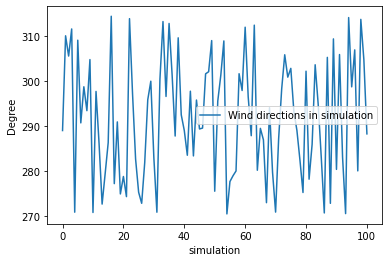

In [101]:
plt.plot(wd_scaled, label = "Wind directions in simulation")
plt.ylabel('Degree')
plt.xlabel('simulation')
plt.legend()
plt.show()

(array([12.,  9., 14.,  7.,  9., 10., 10., 12.,  8., 10.]),
 array([270.52713, 274.9221 , 279.31708, 283.71204, 288.107  , 292.50195,
        296.89694, 301.2919 , 305.68686, 310.08185, 314.4768 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

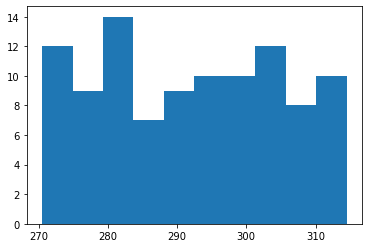

In [106]:
plt.hist(wd_scaled)

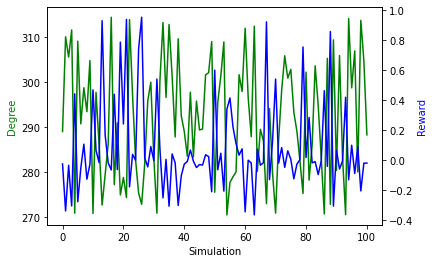

In [105]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(wd_scaled, 'g-')
ax2.plot(rew, 'b')

ax1.set_xlabel('Simulation')
ax1.set_ylabel('Degree', color='g')
ax2.set_ylabel('Reward', color='b')

#plt.legend()
plt.show()



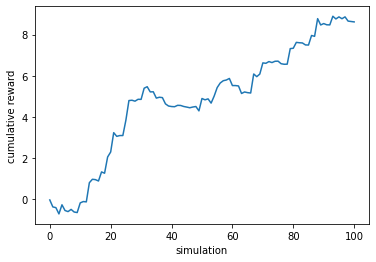

In [113]:
plt.plot(np.cumsum(rew))
plt.xlabel("simulation")
plt.ylabel("cumulative reward")
plt.show()

In [122]:
sort_ind = wd_scaled.argsort()
wd_sorted = wd_scaled[sort_ind[::-1]]
rew_sorted = rew[sort_ind[::-1]]

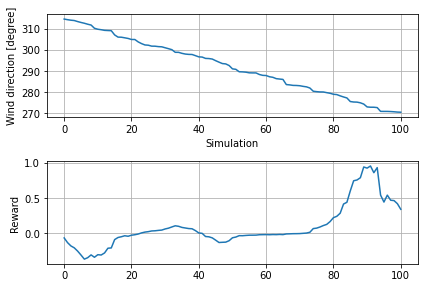

In [126]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(wd_sorted)
#axs[0].set_xlim(0, 2)
axs[0].set_xlabel('Simulation')
axs[0].set_ylabel('Wind direction [degree]')
axs[0].grid(True)


axs[1].plot(rew_sorted)
axs[1].set_ylabel('Reward')
axs[1].grid()

fig.tight_layout()
plt.show()